In [1]:
from utils import *
from memory import *

In [2]:
import time
import subprocess
from collections import namedtuple,defaultdict
import logging
import json
import os
import yaml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import sys
import threading
import argparse
import sys
import random
import gym
from torch.utils.tensorboard import SummaryWriter
import copy
import matplotlib.pyplot as plt

# DDPG

In [ ]:
class Q_NN(nn.Module):
    def __init__(self, layers, inSize, outSize):
        super(Q_NN, self).__init__()
        layer1 = layers[0]
        self.fc_s = nn.Linear(inSize, layer1)
        self.fc_a = nn.Linear(outsize, layer1)
        inSize = layers[1]
        self.fc_q = nn.ModuleList([nn.Linear(2*layer1, inSize).float()])
        for x in layers[2:]:
            self.fc_q.append(nn.Linear(inSize, x).float())
            inSize = x
        self.fc_q.append(nn.Linear(inSize, 1).float())
    
    def forward(self, x, a):
        h1 = F.relu(self.fc_s(x))
        h2 = F.relu(self.fc_a(a))
        x = torch.cat([h1,h2], dim=1)
        for layer in self.fc_q[:-1]:
            x = layer(x)
            x = F.relu(x)
        x = self.fc_q[-1](x)
        return x
    
class Pi_NN(nn.Module):
    def __init__(self, layers, inSize, outsize):
        super(Pi_NN, self).__init__()
        self.fc_pi = nn.ModuleList([])
        for x in layers:
            self.fc_pi.append(nn.Linear(inSize, x).float())
            inSize = x
        self.fc_pi.append(nn.Linear(inSize, outsize).float())
    
    def forward(self, x):
        for layer in self.fc_pi[:-1]:
            x = layer(x)
            x = F.relu(x)
        prob = torch.tanh(self.fc_pi[-1](x))
        return prob
    
        
class DDPG:
    def __init__(self,env,capacity,insize,outsize,layersQ,layersPi,mini_batch_size,device,lr_q,lr_pi,d,discount,tau):
        self.device = device
        self.env = env
        self.capacity = capacity
        self.insize = insize
        self.layersQ = layersQ
        self.layersPi = layersPi    
        self.outsize = outsize
        self.D = Memory(self.capacity, prior=False)
        self.Q = Q_NN(self.layersQ, self.insize, self.outsize)
        self.Q_target = copy.deepcopy(self.Q)
        self.Pi = Pi_NN(self.layersPi, self.insize, self.outsize)
        self.Pi_target = copy.deepcopy(self.Pi)
        self.arrayNetworks = [[self.Pi_target,self.Pi],[self.Q_target,self.Q]]
        self.d = d
        self.discount = discount
        self.lr_q = lr_q
        self.lr_pi = lr_pi
        self.Q_optimizer = torch.optim.Adam(self.Q.parameters(), lr=self.lr_q)
        self.Pi_optimizer  = torch.optim.Adam(self.Pi.parameters(), lr=self.lr_pi)
        self.mini_batch_size = mini_batch_size
        self.loss = torch.nn.SmoothL1Loss()
        self.tau = tau    
        
    def act(self, observation, reward, done):
        action = self.Pi(torch.tensor(observation).float()) + np.random.normal(0, 0.1)
        return action.detach()
    
    def act2(self, observation, reward, done):
        action = self.Pi(torch.tensor(observation).float())
        return action.detach()
         
    def updateMemory(self,nuplet):
        self.D.store(nuplet)
        return
    
    def update(self):
        mini_batch = self.D.sample(self.mini_batch_size)
        states, actions, rewards, next_states, y = zip(*mini_batch)
        #print("states",states)
        states = torch.stack(states)
        next_states = torch.stack(next_states)
        actions = torch.stack(actions)
        #print("rewards",rewards)
        rewards = torch.stack(rewards).unsqueeze(dim=1)
        y = torch.stack(y).unsqueeze(dim=1)
        #print("next states",next_states)
        #print("states",states)
        #print("pi states",self.Pi(states))
        #print("actions",actions)
        #print("rewards",rewards)
        #print("y",y)
        target = rewards + self.discount * (1 - self.d) * self.Q_target(next_states, self.Pi_target(next_states)) * y
        #print("QSHAPE",self.Q_target(next_states, self.Pi_target(next_states)).shape)
        #print("target shape",target.shape)
        q_loss = self.loss(self.Q(states, actions), target.detach())
        self.Q_optimizer.zero_grad()
        q_loss.backward()
        self.Q_optimizer.step()
        pi_loss = -self.Q(states, self.Pi(states)).mean()
        self.Pi_optimizer.zero_grad()
        pi_loss.backward()
        self.Pi_optimizer.step()
        for net_target,net in self.arrayNetworks:
            for param_target, param in zip(net_target.parameters(), net.parameters()):
                param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        return

In [4]:
class RandomAgent(object):
    """The world's simplest agent!"""

    def __init__(self, env, opt):
        self.opt=opt
        self.env=env
        if opt.fromFile is not None:
            self.load(opt.fromFile)
        self.action_space = env.action_space
        self.featureExtractor = opt.featExtractor(env)

    def act(self, observation, reward, done):
        return self.action_space.sample()

    def save(self,outputDir):
        pass

    def load(self,inputDir):
        pass


In [5]:
def runDDPG(envName,device,nb_epochs, capacity=50000, layersQ=[64,32], layersPi=[128, 64], mini_batch_size=32,  lr_q=0.001, lr_pi=0.0005, d=0.0005, minBufferSize=2000, discount=0.99, tau = 0.005, freqTest = 20):
    if envName == "LunarLanderContinuous-v2":
        insize = 8
        outsize = 2
    elif envName == "MountainCarContinuous-v0":
        insize = 2
        outsize = 1
    elif envName == "Pendulum-v0":
        insize = 3
        outsize = 1
    env = gym.make(envName)
    tstart = str(time.time())
    tstart = tstart.replace(".", "_")
    outdir = "./XP/" + envName + "/random_" + "-" + tstart
    previous_ob = env.reset()
    agent = DDPG(env, capacity=capacity, insize=insize, outsize=outsize, layersQ=layersQ, layersPi=layersPi, mini_batch_size=mini_batch_size, device=device, lr_q=lr_q, lr_pi=lr_pi, d=d, discount=discount, tau=tau)
    print("Saving in " + outdir)
    os.makedirs(outdir, exist_ok=True)
    save_src(os.path.abspath(outdir))
    logger = LogMe(SummaryWriter(outdir))
    loadTensorBoard(outdir)
    rsum = 0
    mean = 0
    verbose = True
    freqVerbose = 10
    itest = 0
    reward = 0
    done = False
    arrReward = []
    arrMeanReward = []
    arrTest = []
    cpt = 0
    for i in range(nb_epochs):
        if i % freqVerbose == 0 and i >= freqVerbose:
            verbose = False
        else:
            verbose = False
        if i % freqTest == 0 and i >= freqTest:  ##### Same as train for now
            print("End of test, mean reward over the last {} actions: {}".format(freqTest,mean / freqTest))
            arrMeanReward.append(mean / freqTest)
            itest += 1
            print("New test time! ")
            mean = 0
            #agent.test = True
            """j = 0
            done = False
            while not done:
                action = agent.act2(previous_ob, reward, done)
                ob, reward, done, _ = env.step(action.numpy())
                cpt += 1
                previous_ob = ob
                j += 1
                rsum += reward
                if done:
                    reward = 0
                    print("TEST:" + str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions ")
                    #logger.direct_write("reward", rsum, i)
                    agent.nbEvents = 0
                    mean += rsum
                    arrTest.append(rsum)
                    rsum = 0
                    previous_ob = env.reset()
                    break"""
            

        """if i % freqTest == nbTest and i > freqTest:
            #logger.direct_write("rewardTest", mean / nbTest, itest)
            agent.test = False"""
            
        """if i % freqSave == 0:
            agent.save(outdir + "/save_" + str(i))"""

        j = 0
        if verbose:
            env.render()
        done = False
        while not done:
            if verbose:
                env.render()
                
            action = agent.act(previous_ob, reward, done)
            #print("action",action)
            ob, reward, done, _ = env.step(action.numpy())
            agent.updateMemory((torch.tensor(previous_ob).float(), action, torch.tensor(reward/100.0).float(), torch.tensor(ob).float(), torch.tensor(int(not done)).float()))
            cpt += 1
            previous_ob = ob
            j += 1
            rsum += reward
            if done:
                reward = 0
                print(str(i) + " rsum=" + str(rsum) + ", " + str(j) + " actions ")
                #logger.direct_write("reward", rsum, i)
                arrReward.append(rsum)
                agent.nbEvents = 0
                mean += rsum
                rsum = 0
                previous_ob = env.reset()
                break
        if cpt>minBufferSize:
            for i in range(10):
                agent.update()
                #print("Q",[elt for elt in agent.Q.fc_out.parameters()])
                #print("Qtarget",[elt for elt in agent.Q_target.fc_out.parameters()])

    env.close()
    plt.plot([i for i in range(len(arrReward))],arrReward,label="Reward")
    plt.plot([i*freqTest for i in range(1,itest+1)],arrMeanReward,label="Reward moyen sur {} itérations (train)".format(freqTest))
    #plt.plot([i*freqTest for i in range(1,itest+1)],arrTest,label="Reward en test")
    plt.xlabel("Epoch")
    plt.ylabel("Reward")
    plt.title("Algorithme DDPG, monde {}".format(envName))
    plt.legend()
    plt.show()
    #plt.plot([i for i in range(len(agent.arrdkl))],agent.arrdkl)
    return agent, arrReward, arrMeanReward

# Pendulum-v0

Saving in ./XP/Pendulum-v0/random_-1611270535_7865767
tensorboard --logdir=./XP/Pendulum-v0/random_-1611270535_7865767
0 rsum=-1092.7994926994106, 200 actions 
1 rsum=-1901.8548389391283, 200 actions 
2 rsum=-1367.146713260333, 200 actions 
3 rsum=-1053.1194065918426, 200 actions 
4 rsum=-1260.0587373956764, 200 actions 
5 rsum=-1267.167044563622, 200 actions 
6 rsum=-1682.9601790524423, 200 actions 
7 rsum=-971.2935629990368, 200 actions 
8 rsum=-1484.2930716051756, 200 actions 
9 rsum=-1246.784484608285, 200 actions 
10 rsum=-1120.4375378968502, 200 actions 
11 rsum=-1191.0094229702743, 200 actions 
12 rsum=-1150.795673693829, 200 actions 
13 rsum=-1106.588336598776, 200 actions 
14 rsum=-1649.0872682301917, 200 actions 
15 rsum=-1348.0523663440003, 200 actions 
16 rsum=-1627.5278909789588, 200 actions 
17 rsum=-1730.436889653137, 200 actions 
18 rsum=-1359.2148829847176, 200 actions 
19 rsum=-1625.6990120227115, 200 actions 
End of test, mean reward over the last 20 actions: -1361.8

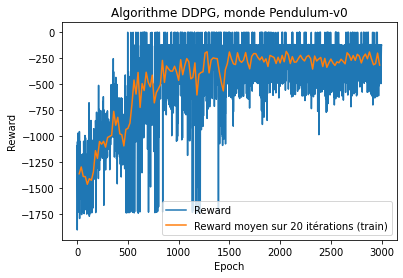

In [107]:
device = torch.device('cpu')
nb_epochs = 3000
agent, arrReward, arrMeanReward = runDDPG("Pendulum-v0",device,nb_epochs, capacity=50000, layersQ=[64,32], layersPi=[128, 64], mini_batch_size=32,  lr_q=0.001, lr_pi=0.0005, d=0.0005, minBufferSize=2000, discount=0.99, tau=0.005, freqTest = 20)